# News Summarizer_Part 1

In [2]:
import re
import string
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim import corpora, models, similarities, matutils
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, confusion_matrix, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sumy.parsers.plaintext import PlaintextParser
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from wordcloud import WordCloud


plt.style.use('ggplot')
%matplotlib inline

In [3]:
names = np.arange(1,4)
articles = ['articles{}.csv'.format(name) for name in names]
source = pd.concat([pd.read_csv(article) for article in articles]).reset_index(drop=True)
source.drop(['Unnamed: 0', 'id', 'month', 'url'], axis=1, inplace=True)

In [4]:
publisher = {'New York Times': 1, 'Breitbart': 2, 'CNN': 3, 'Business Insider': 4, 
             'Atlantic': 5, 'Fox News': 6, 'Talking Points Memo': 7, 'Buzzfeed News': 8,
             'National Review': 9, 'New York Post': 10, 'Guardian': 11, 'NPR': 12, 
             'Reuters': 13, 'Vox': 14, 'Washington Post': 15}
source['publisher'] = [publisher[item] for item in source.publication]

In [7]:
source.head()

,title,publication,author,date,year,content,publisher
0,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,WASHINGTON — Congressional Republicans have...,1
1,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,"After the bullet shells get counted, the blood...",1
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,"When Walt Disney’s “Bambi” opened in 1942, cri...",1
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,"Death may be the great equalizer, but it isn’t...",1
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,"SEOUL, South Korea — North Korea’s leader, ...",1


In [6]:
descending_order = source['publication'].value_counts().sort_values(ascending=False).index

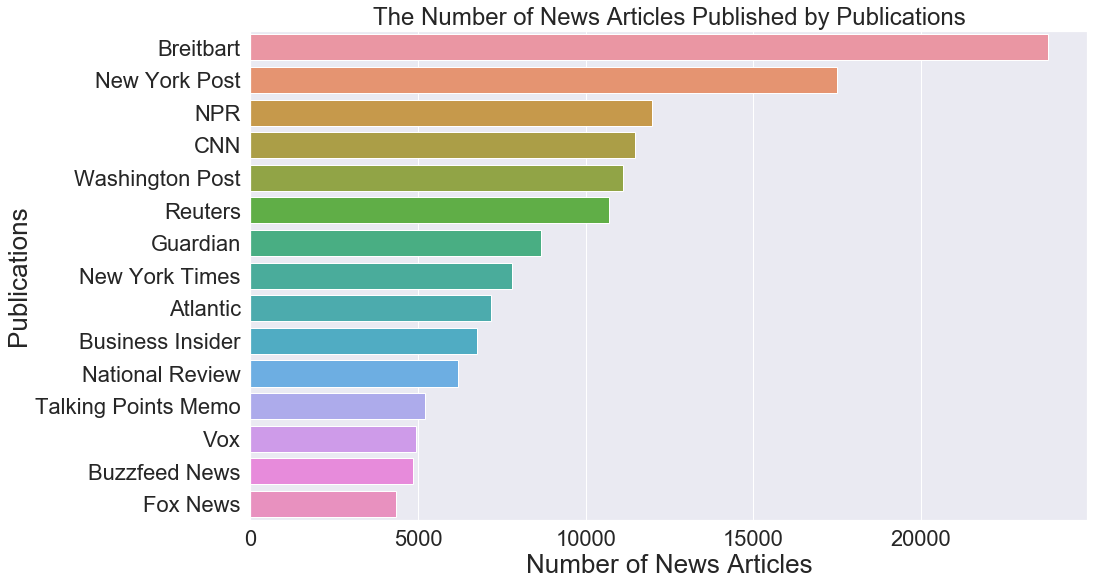

In [8]:
for_plotting = source.publication.astype('category')
plt.figure(figsize=(15,9))
sns.set(font_scale = 2)
ax = sns.countplot(y=for_plotting, order=descending_order)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
plt.xlabel('Number of News Articles', fontsize=26)
plt.ylabel('Publications', fontsize=26)
plt.title('The Number of News Articles Published by Publications');

## Multiclass Classification

In [8]:
news_content = source['content']

In [9]:
count_vectorizer = CountVectorizer(analyzer='word', stop_words='english', min_df=0.05, max_features=900)
count_data = count_vectorizer.fit_transform(news_content)
# entire_data = count_vectorizer.transform([news_content_withpunc[0]])
count_data.shape

(142570, 900)

In [10]:
y = source.publisher
X = count_data

In [ ]:
# Tried: Logit, LinearSVC

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [15]:
pd.Series(y_train).value_counts()

2     19024
10    14005
12     9591
3      9138
15     8891
13     8583
11     6918
1      6230
5      5773
4      5378
9      4970
7      4187
14     3971
8      3925
6      3472
Name: publisher, dtype: int64

In [16]:
# Decision Tree
parameters = {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
}

model_tunning = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, scoring='f1_micro')

model_tunning.fit(X_train, y_train)

print(model_tunning.best_score_)
print(model_tunning.best_params_)

0.38738865118888965
{'max_depth': 5, 'min_samples_leaf': 6}


In [20]:
# ExtraTreesClassifier
parameters = {
        'n_estimators': [50,100,200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
}

model_tunning = GridSearchCV(ExtraTreesClassifier(), parameters, cv=5, scoring='f1_micro')

model_tunning.fit(X_train, y_train)

print(model_tunning.best_score_)
print(model_tunning.best_params_)

0.1894244932313951
{'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}


In [18]:
# GaussianNB
parameters = {
        'priors': [None]
}

model_tunning = GridSearchCV(GaussianNB(), parameters, cv=5, scoring='f1_micro')

model_tunning.fit(X_train.toarray(), y_train)

print(model_tunning.best_score_)
print(model_tunning.best_params_)

0.32306060180963736
{'priors': None}


## Sentiment Analysis

In [16]:
news_content = source['content']
news_content = [text.lower() for text in news_content]
news_content = [re.sub( '\s+', ' ', text).strip() for text in news_content]

In [21]:
content_sentiment = [TextBlob(text) for text in news_content]
polarity = [text.sentiment.polarity for text in content_sentiment]

In [84]:
source['polarity'] = polarity

In [86]:
source.head()

,title,publication,author,date,year,content,publisher,polarity
0,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,WASHINGTON — Congressional Republicans have...,1,0.028842
1,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,"After the bullet shells get counted, the blood...",1,-0.001750
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,"When Walt Disney’s “Bambi” opened in 1942, cri...",1,0.067972
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,"Death may be the great equalizer, but it isn’t...",1,0.129795
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,"SEOUL, South Korea — North Korea’s leader, ...",1,0.186427


## Word Cloud

In [55]:
for_wordcloud = count_vectorizer.get_feature_names()
for_wordcloud = for_wordcloud[26:]
for_wordcloud_str = ' '.join(for_wordcloud)

In [73]:
wordcloud = WordCloud(width=800, height=400, background_color ='white',
                      min_font_size = 7).generate(for_wordcloud_str)

In [148]:
wordcloud.words_

{'action': 1.0,
 'american': 1.0,
 'area': 1.0,
 'attack': 1.0,
 'candidate': 1.0,
 'case': 1.0,
 'change': 1.0,
 'charge': 1.0,
 'claim': 1.0,
 'come': 1.0,
 'comment': 1.0,
 'cost': 1.0,
 'day': 1.0,
 'democrat': 1.0,
 'effort': 1.0,
 'election': 1.0,
 'event': 1.0,
 'force': 1.0,
 'friend': 1.0,
 'group': 1.0,
 'hand': 1.0,
 'issue': 1.0,
 'job': 1.0,
 'know': 1.0,
 'law': 1.0,
 'leader': 1.0,
 'live': 1.0,
 'look': 1.0,
 'make': 1.0,
 'mean': 1.0,
 'member': 1.0,
 'million': 1.0,
 'month': 1.0,
 'nation': 1.0,
 'need': 1.0,
 'new': 1.0,
 'number': 1.0,
 'officer': 1.0,
 'official': 1.0,
 'place': 1.0,
 'plan': 1.0,
 'point': 1.0,
 'problem': 1.0,
 'question': 1.0,
 'reason': 1.0,
 'remain': 1.0,
 'report': 1.0,
 'reporter': 1.0,
 'republican': 1.0,
 'result': 1.0,
 'right': 1.0,
 'rule': 1.0,
 'say': 1.0,
 'service': 1.0,
 'source': 1.0,
 'state': 1.0,
 'student': 1.0,
 'term': 1.0,
 'thing': 1.0,
 'time': 1.0,
 'view': 1.0,
 'vote': 1.0,
 'want': 1.0,
 'way': 1.0,
 'week': 1.0,
 '

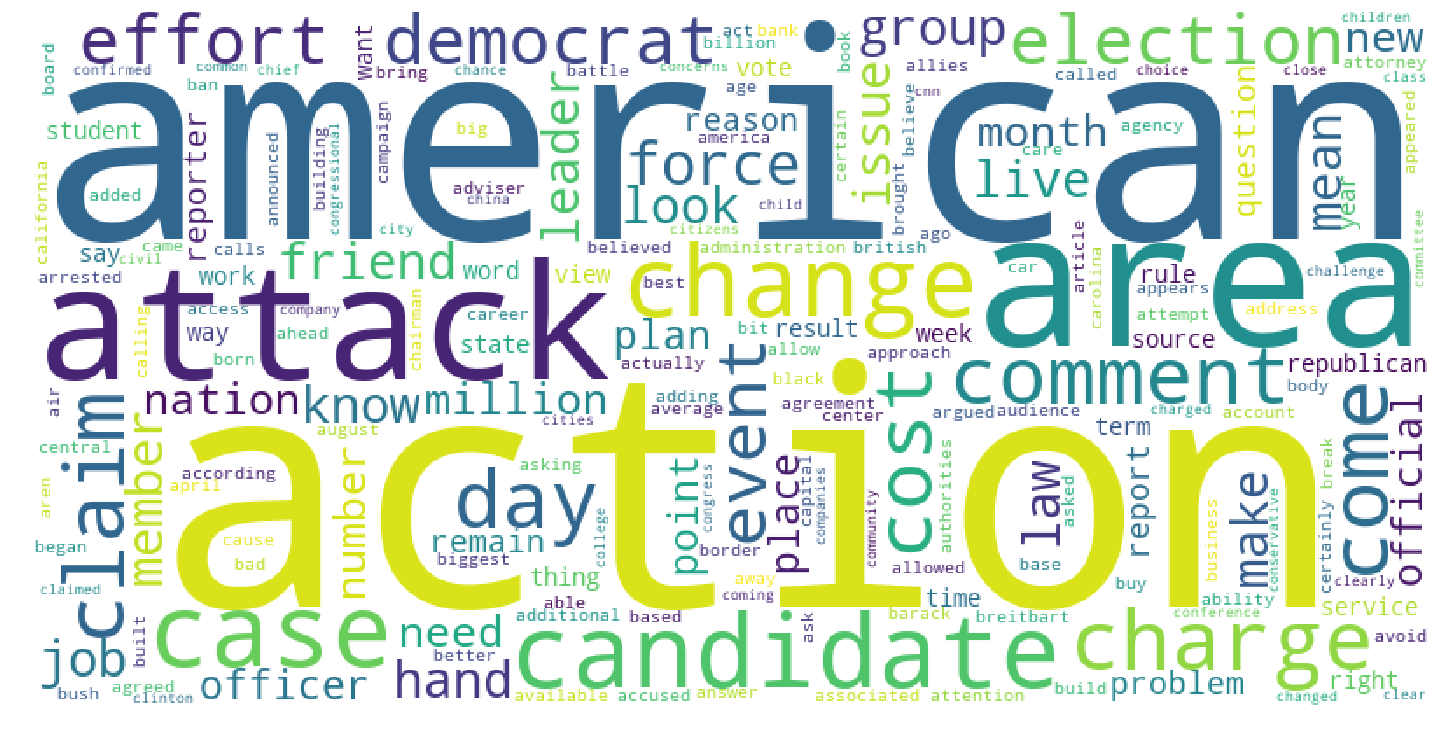

In [76]:
plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
 
plt.show()